# Model Order Selection for Neural Data

**Name**: \[Luxi Zhang\] **Net ID**: \[lz3546\]

Make a copy of this notebook in your own Google Drive and, as you work through it, fill in missing code and answers to the questions.

After you are finished, you will copy your answers from individual sections *and* a copy of the entire notebook into PrairieLearn for submission. (Note that the PrairieLearn autograder will expect that you have used exactly the variable names shown in this template notebook.)

Answers to open-ended questions (e.g. “Comment on the results..”) must be **in your own words**, reflecting your own interpretation and understanding, and must refer to specific results (including numeric values) you obtained in this notebook.

**Attribution**: This notebook is a slightly adapted version of the [model order selection lab assignment](https://github.com/sdrangan/introml/blob/master/unit04_model_sel/lab_neural_partial.ipynb) by Prof. Sundeep Rangan.

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain. In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces. In this notebook, you will use model selection for performing some simple analysis on real neural signals.

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short"> Stevenson, Ian H., et al. “Statistical assessment of the stability of neural movement representations.” Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain. Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls. These spikes trigger the electro-chemical signals between one neuron and another. In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain. During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.

The goal of the experiment is to try to *read the monkey's brain*: That is, predict the hand motion from the neural signals from the motor cortex.

We first load the key packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

The full data is available on the CRCNS website <http://crcns.org/data-sets/movements/dream>. However, the raw data files can be quite large. To make the lab easier, the [Kording lab](http://kordinglab.com/) at UPenn has put together an excellent [repository](https://github.com/KordingLab/Neural_Decoding) where they have created simple pre-processed versions of the data. You can download the file `example_data_s1.pickle` from the [Dropbox link](https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=0). Alternatively, you can directly run the following command. This may take a little while to download since the file is 26 MB.

In [2]:
!wget 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1' -O example_data_s1.pickle

--2025-10-07 14:46:03--  https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fo/h6u1zn1txqrgf0eyko8xu/AAt1EkEOGQAKdmOiyCSxdGY/example_data_s1.pickle?rlkey=wnriqis4p52evt38btpmijane&dl=1 [following]
--2025-10-07 14:46:03--  https://www.dropbox.com/scl/fo/h6u1zn1txqrgf0eyko8xu/AAt1EkEOGQAKdmOiyCSxdGY/example_data_s1.pickle?rlkey=wnriqis4p52evt38btpmijane&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc1a5a9b6deb09b8624be9e75ad.dl.dropboxusercontent.com/cd/0/inline/CyzaOXvJB2H1olompEGFjW07CEs-kFBqDflO-0opqMmwGPc7aBSsuZO272EEuzM9U3rfrFcnBWvlzTPydObXQFgAoxVRKSHIgT-KhU56axf6FWd2X9rCB4Lb4N5xORyK-Fs/file?dl=1# [followin

The file is a *pickle* data structure, which uses the Python package `pickle` to serialize Python objects into data files. Once you have downloaded the file, you can run the following command to retrieve the data from the pickle file.

In [3]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

The matrix `X` is matrix of spike counts from different neurons, where `X[i,j]` is the number of spikes from neuron `j` in time bin `i`.

The matrix `y` has two columns:

-   `y[i,0] =` velocity of the monkey's hand in the x-direction in time bin `i`
-   `y[i,1] =` velocity of the monkey's hand in the y-direction in time bin `i`

Our goal will be to predict `y` from `X`.

Each time bin represent `tsamp=0.05` seconds of time. Using `X.shape` and `y.shape`, we can compute and print:

-   `nt =` the total number of time bins
-   `nneuron =` the total number of neurons
-   `nout =` the total number of output variables to track = number of columns in `y`
-   `ttotal =` total time of the experiment is seconds.

In [4]:
tsamp = 0.05  # sampling time in seconds

nt, nneuron = X.shape
nout = y.shape[1]
ttotal = nt*tsamp

print('Number of neurons = %d' % nneuron)
print('Number of time samples = %d' % nt)
print('Number of outputs = %d' % nout)
print('Total time (secs) = %f' % ttotal)

Number of neurons = 52
Number of time samples = 61339
Number of outputs = 2
Total time (secs) = 3066.950000


Then, we can plot the velocity against time, for each direction, for the first 1000 samples:

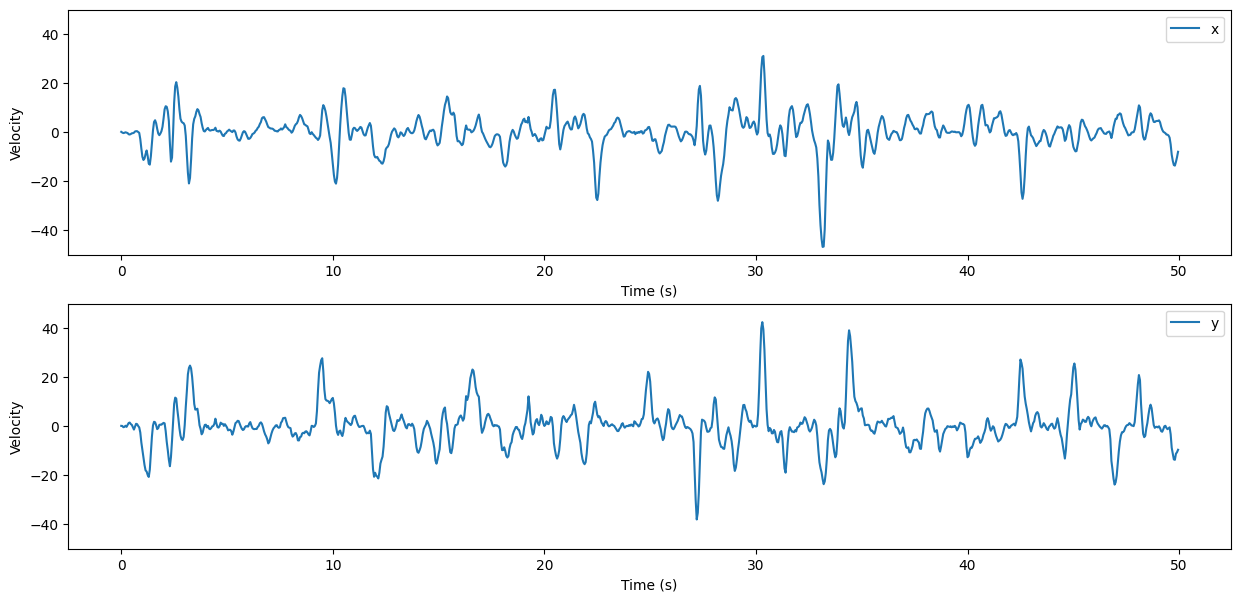

In [5]:
t_cutoff = 1000
directions = ['x', 'y']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,7))
for n in range(nout):
  sns.lineplot(x=np.arange(0, t_cutoff)*tsamp, y=y[0:t_cutoff, n], label=directions[n], ax=axes[n]);

  axes[n].set_ylabel("Velocity")
  axes[n].set_xlabel("Time (s)")
  axes[n].set_ylim(-50,50)

We can also “zoom in” on a small slice of time in which the monkey is moving the hand, and see the neural activity at the same time.

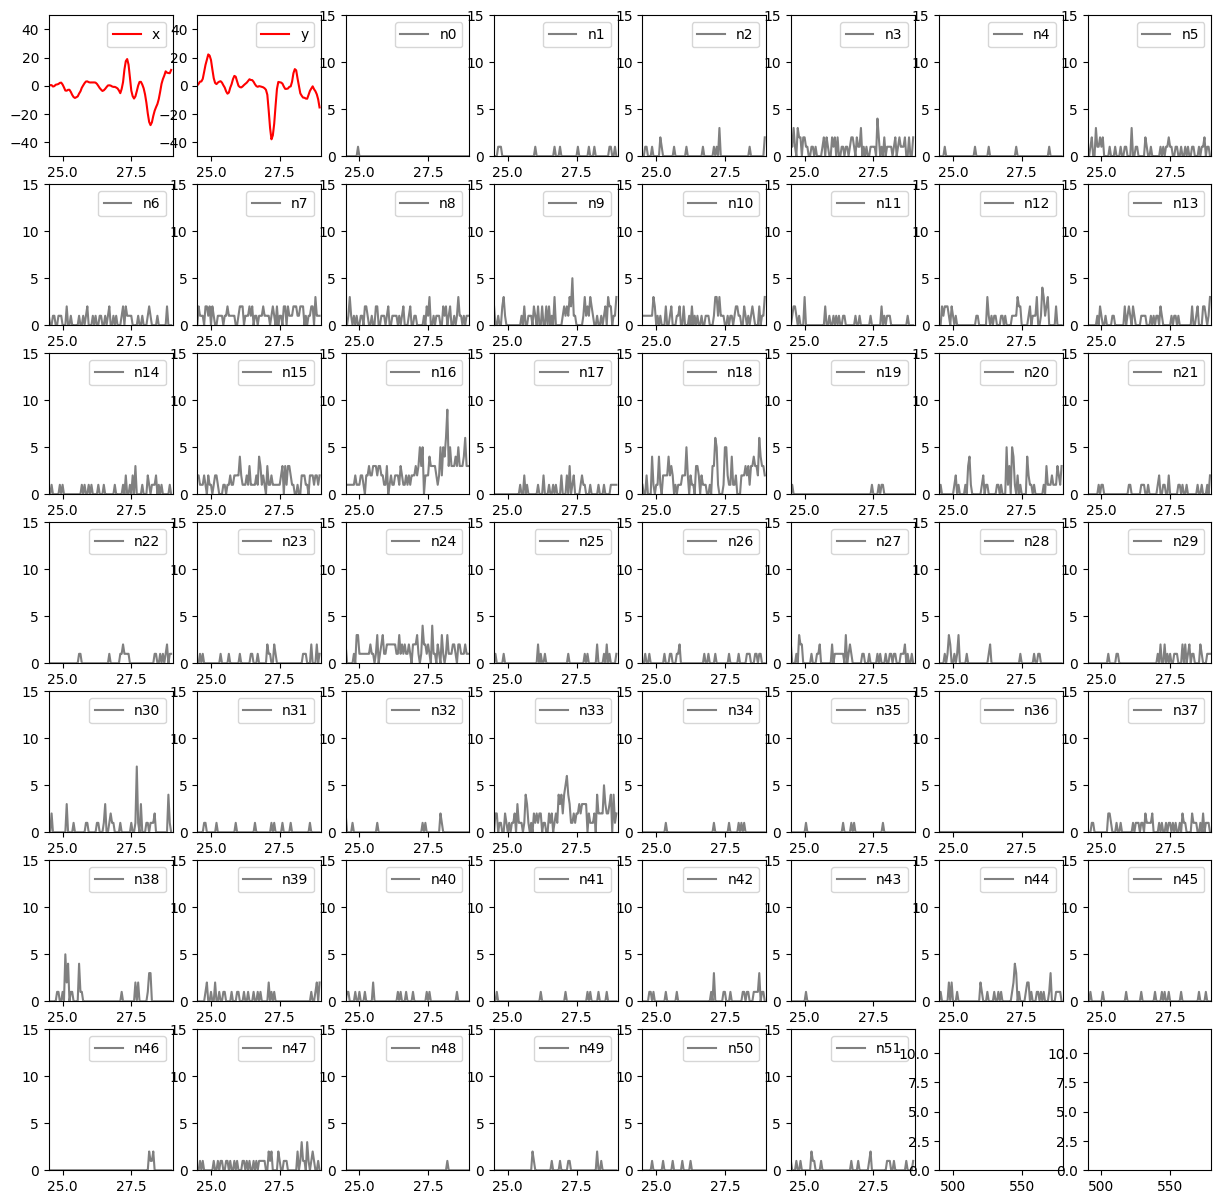

In [6]:
t_start = 490
t_end = 580

fig, axes = plt.subplots(nrows=7, ncols=8, figsize=(15,15))

# Setting the range for all axes
plt.setp(axes, xlim=(t_start, t_end), ylim=(0,12));

for n in range(nout):
  sns.lineplot(x=np.arange(t_start, t_end)*tsamp, y=y[t_start:t_end, n], ax=axes[n//2,n%2], color='red', label=directions[n])
  plt.setp(axes[n//2,n%2], xlim=(t_start*tsamp, t_end*tsamp), ylim=(-50, +50));

for n in range(nneuron):
  sns.lineplot(x=np.arange(t_start, t_end)*tsamp, y=X[t_start:t_end, n], ax=axes[(n+2)//8,(n+2)%8], label="n%d" % n, color='grey')
  plt.setp(axes[(n+2)//8,(n+2)%8], xlim=(t_start*tsamp, t_end*tsamp), ylim=(0, +15));


## 1. Fitting a linear model

Let’s first try a linear regression model to fit the data.

To start, we will split the data into a training set and a test set. We’l fit the model on the training set and then use the test set to estimate the model performance on new, unseen data.

**To shuffle or not to shuffle?**

The `train_test_split` function has an optional `shuffle` argument.

-   If you use `shuffle=False`, then `train_test_split` will take the first part of the data as the training set and the second part of the data as the test set, according to the ratio you specify in `test_size` or `train_size`.
-   If you use `shuffle=True`, then `train_test_split` will first randomly shuffle the data. Then, it will take the first part of the *shuffled* data as the training set and the second part of the *shuffled* data as the test set, according to the ratio you specify in `test_size` or `train_size`.

According to the function [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), by default, `shuffle` is `True`:

> **shuffle: bool, default=True**
>
> Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

so if you do not specify anything related to `shuffle`, your data will be randomly shuffled before it is split into training and test data.

Under what conditions should you shuffle data? Suppose your dataset includes samples of a medical experiment on 1000 subjects, and the first 500 samples in the data are from male subjects while the second 500 samples are from female subjects. If you set `shuffle=False`, then your training set would have a much higher proportion of male subjects than your test set (with the specific numbers depending on the ratio you specify).

On the other hand, suppose your dataset includes stock prices at closing time, with each sample representing a different date (in order). If you allow `train_test_split` to shuffle the data, then your model will be allowed to “learn” stock prices using prices from the day *after* the one it is trying to predict! Obviously, your model won’t be able to learn from future dates in production, so it shouldn’t be allowed to in the evaluation stage, either. (Predicting the past using the future is considered a type of data leakage.)

With this in mind, it is usually inappropriate to shuffle time series data when splitting it up into smaller sets for training, validation, or testing.

(There are more sophisticated ways to handle splitting time series data, but for now, splitting it up the usual way, just without shuffling first, will suffice.)

Given the discussion above, use the `train_test_split` function to split the data into training and test sets, but with no shuffling. Let `Xtr,ytr` be the training data set and `Xts,yts` be the test data set. Use `test_size=0.33` so 1/3 of the data is used for evaluating the model performance.

In [7]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
# TODO: Split data intro training and test sets
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.33, shuffle=False)

Now, fit a linear regression on the training data `Xtr,ytr`. Make a prediction `yhat_no_dly` using the test data, `Xts`. Compare `yhat_no_dly` to `yts` to measure `rsq_no_dly`, the R2 value. Use the sklearn `r2_score` method.

In [8]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
# TODO: Fit a linear model
lr = LinearRegression()
lr.fit(Xtr, ytr)
yhat_no_dly = lr.predict(Xts)
rsq_no_dly  = r2_score(yts, yhat_no_dly)

Print the `rsq_no_dly` value. You should get `rsq_no_dly` of around `0.45`.

In [9]:
rsq_no_dly

0.4499831346553008

It is useful to plot the predicted vs. actual values. Use the test data for this visualization. Create a scatter plot of predicted values ($\hat{y}$) on the vertical axis, and actual values ($y$) on the horizontal axis. Since we have two predicted values for each sample - the velocity in the X direction and the velocity in the Y direction - you should make two subplots,

-   one of predicted X direction vs. actual X direction,
-   one of predicted Y direction vs. actual Y direction

Make sure both axes use the same scale (the range of the vertical axis should be the same as the range of the horizontal axis) *and* that all subplots use the same scale. Label each axes, and each plot (indicate which plot shows the velocity in the X direction and which shows the velocity in the Y direction!) Also, the plot area for each subplot should be square-shaped (similar height and width) in order to make the relevant trend easier to see.

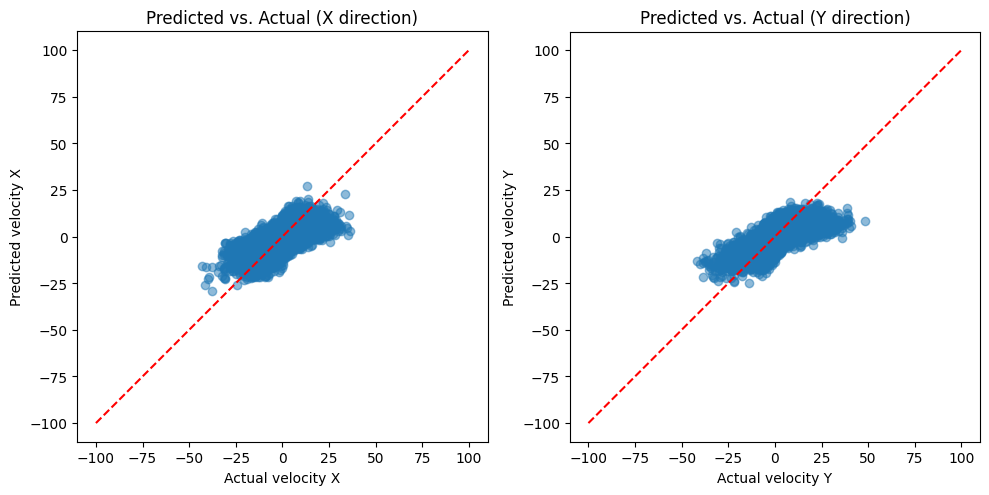

In [31]:
# TODO: Predicted values vs true values visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# scatter for X-direction velocity
axes[0].scatter(yts[:, 0], yhat_no_dly[:, 0], alpha=0.5)
axes[0].plot([-100, 100], [-100, 100], 'r--')  # 45° reference line
axes[0].set_xlabel("Actual velocity X")
axes[0].set_ylabel("Predicted velocity X")
axes[0].set_title("Predicted vs. Actual (X direction)")
axes[0].axis("square")

# scatter for Y-direction velocity
axes[1].scatter(yts[:, 1], yhat_no_dly[:, 1], alpha=0.5)
axes[1].plot([-100, 100], [-100, 100], 'r--')
axes[1].set_xlabel("Actual velocity Y")
axes[1].set_ylabel("Predicted velocity Y")
axes[1].set_title("Predicted vs. Actual (Y direction)")
axes[1].axis("square")

plt.tight_layout()
plt.show()


It can also be useful to visualize the actual and predicted values over time, for a slice of time. Use the test data for this visualization. Create two subplots, both with time on the horizontal axis, but only including *the first 1000 rows* (50 seconds) in the data. On the vertical axis,

-   for one subplot: show the actual X direction as a line of one color, and the predicted X direction as a line of another color.
-   for the second subplot: show the actual Y direction as a line of one color, and the predicted Y direction as a line of another color.

Make sure to carefully label each axis (including units on the time axis!), and label the data series (i.e. which color is the actual value and which is the predicted value). Use solid lines (not dashed or dotted). Use similar dimensions as the “velocity vs. time” plot above.

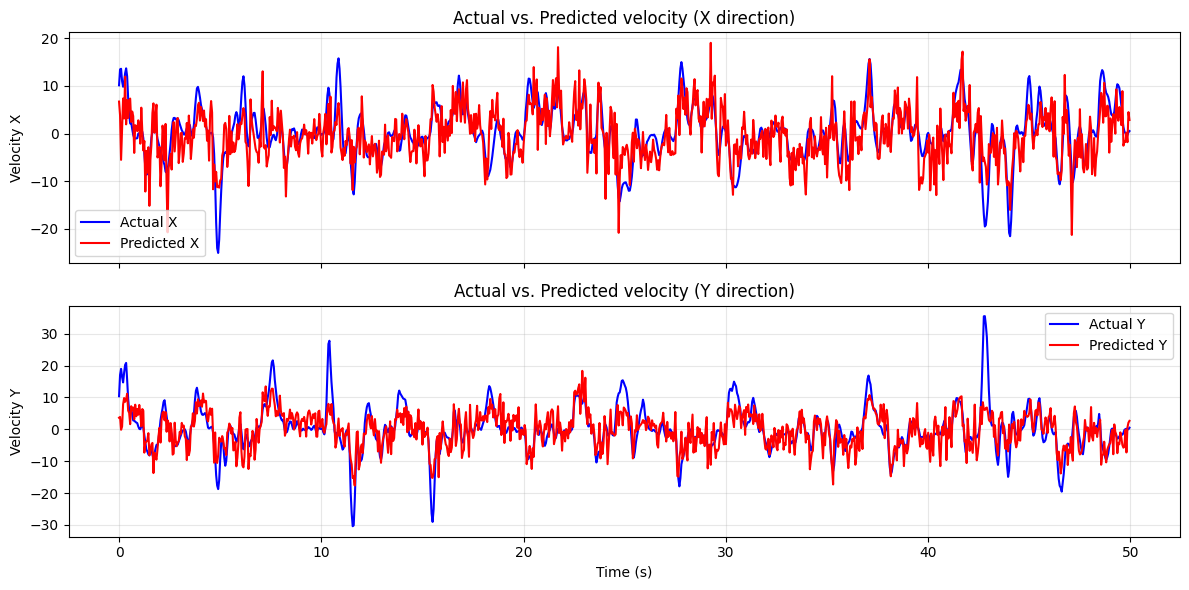

In [32]:
# TODO: Predicted and true values over time visualization
t = np.arange(1000) * tsamp  # tsamp defined earlier (0.05 s)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# --- X direction ---
axes[0].plot(t, yts[:1000, 0], label="Actual X", color='blue')
axes[0].plot(t, yhat_no_dly[:1000, 0], label="Predicted X", color='red')
axes[0].set_ylabel("Velocity X")
axes[0].set_title("Actual vs. Predicted velocity (X direction)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Y direction ---
axes[1].plot(t, yts[:1000, 1], label="Actual Y", color='blue')
axes[1].plot(t, yhat_no_dly[:1000, 1], label="Predicted Y", color='red')
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Velocity Y")
axes[1].set_title("Actual vs. Predicted velocity (Y direction)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Comment on this plot - does the model predict the hand velocity well?

## 2. Fitting a model with delay

One way we can improve the model accuracy is to add features using delayed version of the existing features.

Specifically, the model we used above tries to predict velocity in direction $k$ at time $i$ using

$$\hat{y}_{i,k} = w_{k,0} + \sum_{d=1}^{\text{nneuron}} w_{k,d} X_{i,d}  $$

In this model, $\hat{y}_{i,k}$ at the $i$th time bin was only dependent on $X_i$, the number of spikes of each neuron in time bin $i$. In signal processing, this is called a *memoryless* model.

However, in many physical systems, such as those that arise in neuroscience, there is a delay between the inputs and outputs. To model this effect, we could add additional features to each row of data, representing the number of spikes of each neuron in the *previous* row. Then, the output at time $i$ would be modeled as the effect of the neurons firing in time $i$ *and* the effect of the neurons firing in time $i-1$.

We wouldn’t be able to use data from the past for the first row of data, since we don’t *have* data about neurons firing in the previous time step. But we can drop that row. If our original data matrix had `nt` rows and `nneuron` columns, our data matrix with delayed features would have `nt - 1` rows and `nneuron + 1 x nneuron` columns. (The first `nneuron` columns represent the number of spikes in each neuron for the current time, the next `nneuron` columns represent the number of spikes in each neuron for the previous time.)

Furthermore, we can “look back” any number of time steps, so that the output at time $i$ is modeled as the effect of the neurons firing in time $i$, the neurons firing in time $i-1$, ..., all the way up to the effect of the neurons firing in time $i- \text{dly}$ (where $\text{dly}$ is the maximum number of time steps we're going to “look back” on). Our data matrix with the additional delayed features would have `nt - dly` rows and `nneuron + dly x nneuron` columns.

Here is a function that accepts `X` and `y` data and a `dly` argument, and returns `X` and `y` with delayed features up to `dly` time steps backward.

In [10]:
def create_dly_data(X,y,dly):
    """
    Create delayed data
    """
    n,p = X.shape
    Xdly = np.zeros((n-dly,(dly+1)*p))
    for i in range(dly+1):
        Xdly[:,i*p:(i+1)*p] = X[dly-i:n-i,:]
    ydly = y[dly:]

    return Xdly, ydly

To convince yourself that this works, try creating a data matrix that includes delayed features one time step back:

In [11]:
X_dly_1, y_dly_1 = create_dly_data(X, y, 1)

Verify that the dimensions have changed, as expected:

In [12]:
# dimensions of original data matrix
X.shape

(61339, 52)

In [13]:
# dimensions of data matrix with delayed features 1 time step back
X_dly_1.shape

(61338, 104)

Check row 0 in the matrix with delayed features, and verify that it is the concatenation of row 1 and row 0 in the original data matrix. (Note that row 0 in the matrix with delayed features corresponds to row 1 in the original data matrix.)

In [14]:
X_dly_1[0]

array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 2., 0., 0., 3., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1.])

In [15]:
np.hstack((X[1], X[0]))

array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 2., 0., 0., 1., 0., 2., 0., 0., 3., 0., 0., 2.,
       2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 0.,
       2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1.])

In [16]:
y_dly_1[0]

array([-0.13949835,  0.11006426])

In [17]:
y[1]

array([-0.13949835,  0.11006426])

Now fit an linear delayed model with `dly=2` delay lags. That is,

-   Create delayed data `X_dly_2, y_dly_2` by calling `create_dly_data` with `dly=2`
-   Split the data (with the extra delay features!) into training and test as before (again, do not shuffle the data, and use a test size of 0.33). Name the training data `Xtr_dly_2, ytr_dly_2` and name the test data `Xts_dly_2, yts_dly_2`.
-   Fit the model on the training data
-   Use the model to predict the values for the test data and save the result in `yhat_dly_2`
-   Measure the R2 score on the test data and save the result in `rsq_dly_2`. (Note: make sure you are comparing the model prediction to the “delayed” test data samples, not the original samples!)

If you did this correctly, you should get a new R2 score around 0.60. This is significantly better than the memoryless model.

In [18]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# TODO: Fit a linear model with dly=2

# Create the delayed data
X_dly_2, y_dly_2 = create_dly_data(X, y, 2)

# Split into training and test
Xtr_dly_2, Xts_dly_2, ytr_dly_2, yts_dly_2 = train_test_split(
    X_dly_2, y_dly_2, test_size=0.33, shuffle=False)


# Create linear regression object
# Fit the model
lr2 = LinearRegression()
lr2.fit(Xtr_dly_2, ytr_dly_2)

# Predict values for test data
yhat_dly_2 = lr2.predict(Xts_dly_2)

# Measure the new r2 score
rsq_dly_2 = r2_score(yts_dly_2, yhat_dly_2)


In [19]:
rsq_dly_2

0.6033897697058301

As before (with the same style requirements as before), plot the predicted vs. true values, but for the model with `dly=2`, with one subplot for X velocity and one subplot for Y velocity.

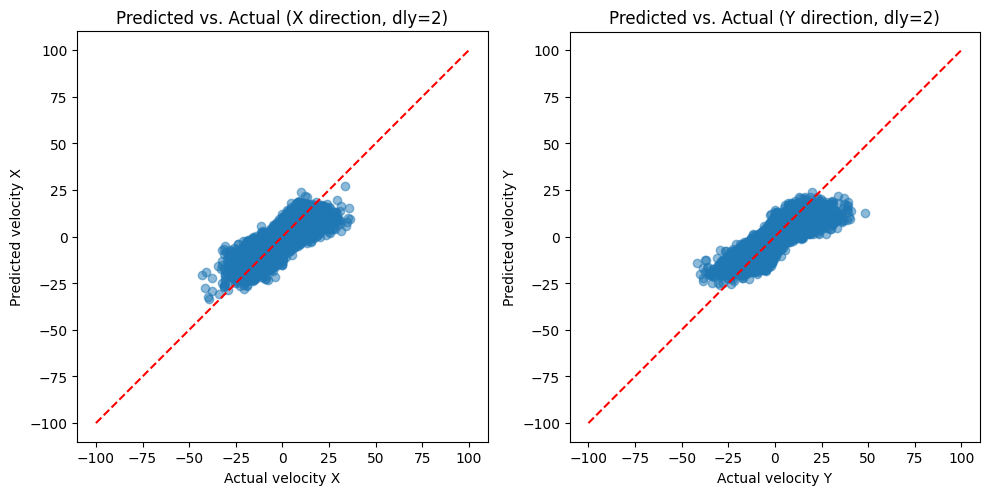

In [33]:
# TODO: Predicted values vs true values visualization with dly=2
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# scatter for X-direction velocity
axes[0].scatter(yts_dly_2[:, 0], yhat_dly_2[:, 0], alpha=0.5)
axes[0].plot([-100, 100], [-100, 100], 'r--')
axes[0].set_xlabel("Actual velocity X")
axes[0].set_ylabel("Predicted velocity X")
axes[0].set_title("Predicted vs. Actual (X direction, dly=2)")
axes[0].axis("square")

# scatter for Y-direction velocity
axes[1].scatter(yts_dly_2[:, 1], yhat_dly_2[:, 1], alpha=0.5)
axes[1].plot([-100, 100], [-100, 100], 'r--')
axes[1].set_xlabel("Actual velocity Y")
axes[1].set_ylabel("Predicted velocity Y")
axes[1].set_title("Predicted vs. Actual (Y direction, dly=2)")
axes[1].axis("square")

plt.tight_layout()
plt.show()


Also as you did before (with the same style requirements as before), plot the actual and predicted values over time for the first 1000 samples, for the model with `dly=2`. (Note: make sure you are comparing the model prediction to the “delayed” test data samples, not the original samples!)

Does the model predict the hand velocity well?

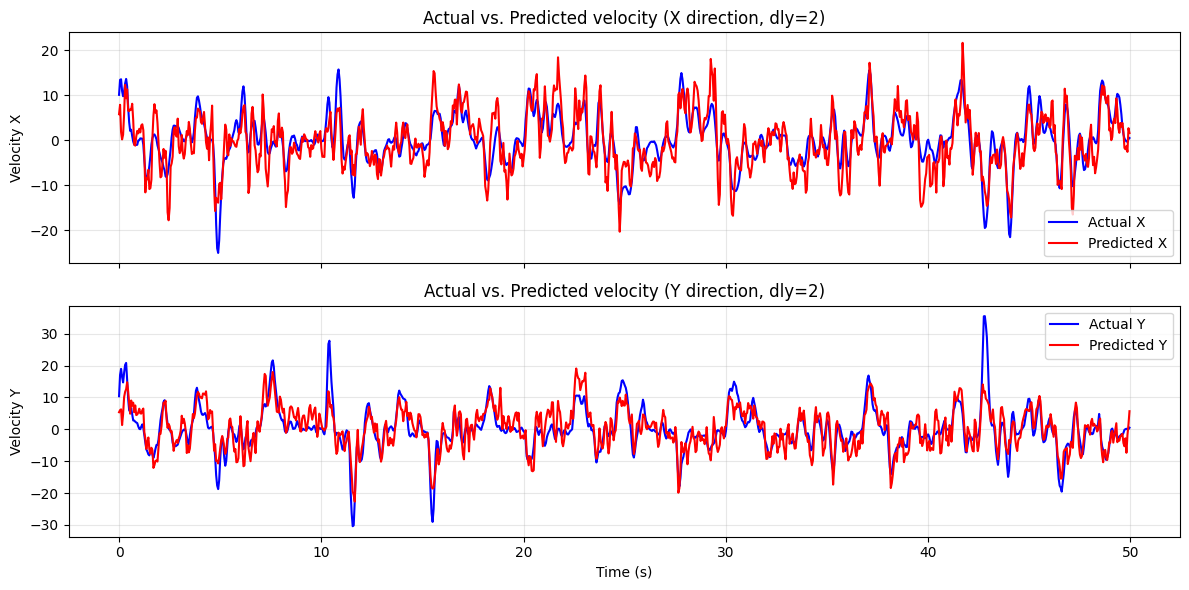

In [34]:
# TODO: Predicted and true values over time visualization with dly=2
t = np.arange(1000) * tsamp  # same 50-second window as before
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# X-direction
axes[0].plot(t, yts_dly_2[:1000, 0], label="Actual X", color="blue")
axes[0].plot(t, yhat_dly_2[:1000, 0], label="Predicted X", color="red")
axes[0].set_ylabel("Velocity X")
axes[0].set_title("Actual vs. Predicted velocity (X direction, dly=2)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Y-direction
axes[1].plot(t, yts_dly_2[:1000, 1], label="Actual Y", color="blue")
axes[1].plot(t, yhat_dly_2[:1000, 1], label="Predicted Y", color="red")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Velocity Y")
axes[1].set_title("Actual vs. Predicted velocity (Y direction, dly=2)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Selecting the optimal delay with K-fold CV

In the previous example, we fixed `dly=2`. We will now select the optimal delay using K-fold cross validation.

Since we have a large number of data samples, it will take a long time to run the K-fold CV for finding the optimal delay. So, to simplify things, we will just pretend that we have a very limited data set, `Xred` and `yred`. In this section, we’ll use the reduced data set `Xred` and `yred` in place of the original `X` and `y`.

We will compute `Xred` and `yred` by taking the first `nred=6000` samples of the data `X` and `y`.

In [20]:
nred = 6000

Xred = X[:nred]
yred = y[:nred]

Note: since we are only using the first 6000 samples to train the model and select the best `dly`, there are plenty of samples left out as the test set. We don’t need to (and shouldn’t) further divide these 6000 samples into training and test sets - we can use all of it for model training and model selection.

We will look at model orders up to `dmax=15`. We will create a delayed data matrix, `X_dly_15,y_dly_15`, using `create_dly_data` with the reduced data `Xred,yred` and `dly=dmax`.

In [21]:
dmax = 15
X_dly_15, y_dly_15 = create_dly_data(Xred,yred,dmax)

In [22]:
X_dly_15.shape

(5985, 832)

In [23]:
y_dly_15.shape

(5985, 2)

We are going to use K-fold CV with `nfold=10` to find the optimal delay, for all the values of delay in `dtest_list`:

In [24]:
dtest_list = np.arange(0, dmax+1)
nd = len(dtest_list)

print(dtest_list)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


You can refer to the example in the “Model order selection” section of the demo notebook. But, make sure to use `shuffle=False` in your `KFold` object, since for this example it would be inappropriate to shuffle the data.

In [27]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
# TODO: Use K-fold CV to select dly

# Number of folds
nfold = 10
#  Create a k-fold object
kf = KFold(n_splits=nfold, shuffle=False)
# features-per-time-slice
p = X.shape[1]
# Precompute X for every candidate delay (use only the (d+1) MOST-RECENT blocks)
X_per_d = [X_dly_15[:, : (d + 1) * p] for d in dtest_list]  # list length = nd

# Initialize a matrix rsq_kf to hold values of the R^2 across the model orders and folds.
rsq_kf = np.zeros((nd,nfold))

# Loop over folds
for i, (idx_tr, idx_val) in enumerate(kf.split(X_dly_15)):
    # Loop over candidate delays
    for it, _ in enumerate(dtest_list):
        Xd = X_per_d[it]           # (nred-d, (d+1)*p)
        yd = y_dly_15              # (nred-d, 2)

        # Split rows for this fold
        Xtr_kf, Xval_kf = Xd[idx_tr], Xd[idx_val]
        ytr_kf, yval_kf = yd[idx_tr], yd[idx_val]

        # Fit and score (LinearRegression as required)
        model_kf = LinearRegression(copy_X=False)  # a tad faster, same result
        model_kf.fit(Xtr_kf, ytr_kf)
        yhat_kf = model_kf.predict(Xval_kf)
        rsq_kf[it, i] = r2_score(yval_kf, yhat_kf)


Write code to find the delay that has the best mean validation R2. Get the best delay according to the “best R2” rule, and save it in `d_opt`. Print the value of `d_opt`.

In [28]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# TODO: Use K-fold CV (continued)
# Pick the delay with the highest mean validation R²
rsq_mean = rsq_kf.mean(axis=1)          # shape (nd,)
best_idx = int(np.argmax(rsq_mean))
d_opt = int(dtest_list[best_idx])


Now write code to find the best delay using the one SE rule (i.e. find the simplest model whose validation R2 is within one SE of the model with the best R2).

-   get the “target R2” that is within one of the “best R2” model, and save it in `rsq_one_se_tgt`
-   then get the delay of the simplest model with R2 greater than this target, and save it in `d_one_se`.

Print the value of `d_one_se`.

In [29]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
# TODO: Use K-fold CV (continued)
# Compute target R² (best mean R² minus its SE), then choose simplest d with mean R² ≥ target
rsq_mean = rsq_kf.mean(axis=1)
rsq_se   = rsq_kf.std(axis=1, ddof=1) / np.sqrt(nfold)

best_idx = int(np.argmax(rsq_mean))
rsq_one_se_tgt = float(rsq_mean[best_idx] - rsq_se[best_idx])

eligible = np.where(rsq_mean >= rsq_one_se_tgt)[0]  # sorted ascending by d
d_one_se = int(dtest_list[int(eligible[0])])


Plot the mean and standard error of the validation R2 values for each model (each delay value) as a function of the delay. Use a `plt.errorbar` plot, as shown in the “Model selection using 1-SE rule” section of the demo notebook. Label each axes.

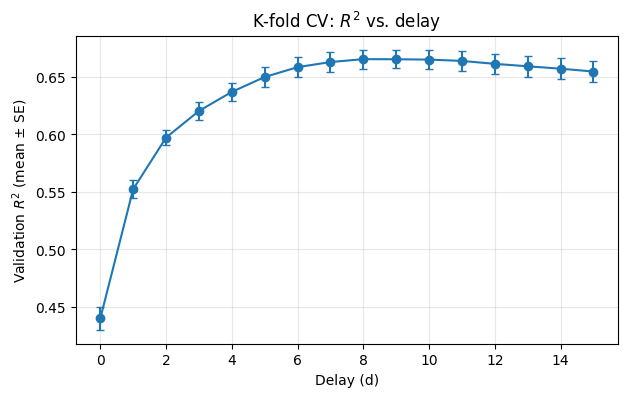

In [30]:
# TODO: Visualize mean and SE of R2 across folds for each dly
# Visualize mean and SE of R2 across folds for each dly
rsq_mean = rsq_kf.mean(axis=1)
rsq_se   = rsq_kf.std(axis=1, ddof=1) / np.sqrt(nfold)

plt.figure(figsize=(7,4))
plt.errorbar(dtest_list, rsq_mean, yerr=rsq_se, fmt='o-', capsize=3)
plt.xlabel("Delay (d)")
plt.ylabel("Validation $R^2$ (mean ± SE)")
plt.title("K-fold CV: $R^2$ vs. delay")
plt.grid(True, alpha=0.3)
plt.show()


Look at the plot, and validate:

-   Does the model with no delay have a similar validation R2 to the value you measured earlier for a memoryless model? (it should have been around 0.45.) You are working with a different (smaller) subset of the data now, so the R2 won’t be exactly the same as before, but it should be similar.
-   Does the model with delay 2 have a similar validation R2 to the value you measured earlier for a delay 2 model? (it should have been around 0.60.) You are working with a different (smaller) subset of the data now, so the R2 won’t be exactly the same as before, but it should be similar.
-   Does the trend (of validation R2 vs delay order) generally match your expectations?

## 4. Fitting the selected model

Now that we have selected a model order, we can fit a linear regression model using the best delay according to the one SE rule.

First, create an “best according to one-SE delay” training and test set

In [ ]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# Un-comment this line:
# X_dly_one_se, y_dly_one_se = create_dly_data(X, y, d_one_se)

# Then, use train_test_split to create Xtr_dly_one_se, ytr_dly_one_se and Xts_dly_one_se, yts_dly_one_se
# (using the same settings as before)
# Xtr_dly_one_se, ytr_dly_one_se = ...
# Xts_dly_one_se, yts_dly_one_se = ...

Then, fit a linear model:

In [ ]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# TODO: Fit a linear model with `dly=d_one_se`


Use your fitted model to get the predictions `yhat_dly_one_se` and find the R2 score `rsq_dly_one_se` on the test set.

Print the value of `rsq_dly_one_se`. It should be substantially better than before.

In [ ]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

# TODO: Fit a linear model with `dly=d_one_se` (continued)
# yhat_dly_one_se = ...
# rsq_dly_one_se = ...

Also plot the actual and predicted values over time for the first 1000 samples of the *test* data (similar to your plots in the previous sections, following the same style requirements). (Note: make sure you are comparing the model prediction to the “delayed” test data samples, not the original samples!)

Comment on this plot - does the model predict the hand velocity well, compared to the previous models?

See if you can identify a few points where this model does noticeably better. Download and *annotate* this plot - circle parts of the time series where the model with one-SE delay is noticably better at predicting the true value than the model with delay = 2.

Comment on the versions of this plot you created for each of the three models (no delay, delay 2, delay with one-SE delay). What is the R2 score of the model in each case? Does the visual improvement you can see in the plot align with your expectations, based on the magnitude of the improvement in R2 score?

In [ ]:
# TODO: Predicted and true values over time for dly=d_one_se visualization

–\>